In [90]:
import math
import torch
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from matplotlib import pyplot as plt
import gpytorch

import pandas as pd
import numpy as np

from gpytorch import lazy


from scripts.utils import train_keys, target_keys
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###  Loading and pre-processing the data

In [2]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl")

In [3]:
# choosing one input dimension and one output dimension as random
input_dim = np.random.permutation(list(train_data.iloc[:,:15].columns))
output_dim = np.random.permutation(list(train_data.iloc[:,15:-1].columns))

In [4]:
print(f"Input dimension to use: {input_dim[0]} and {input_dim[1]}")
print(f"Input dimension to use: {output_dim[0]}")

Input dimension to use: ane and zeff
Input dimension to use: vceitg_gb_div_efiitg_gb


In [5]:
drop_data = train_data[[f'{input_dim[0]}',f'{input_dim[1]}',f'{output_dim[0]}']].dropna()

In [6]:
# drop_data = train_data[['smag','alpha','pfitem_gb_div_efetem_gb']].dropna()

In [7]:
x_train_data = drop_data.iloc[:,:2]
y_train_data = drop_data.iloc[:,2:]

assert x_train_data.shape[0] == y_train_data.shape[0]

In [8]:
n = 100
idx = np.random.permutation(n)

In [9]:
x_train_data = torch.tensor(x_train_data.values)[idx]
y_train_data = torch.tensor(y_train_data.values)[idx]

x_train_data = x_train_data.unsqueeze(0)
y_train_data = y_train_data.unsqueeze(0)

x_min0, x_max0 = x_train_data.min(), x_train_data.max()

In [10]:
gp = SingleTaskGP(x_train_data, y_train_data)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll);

In [11]:
# Get into evaluation (predictive posterior) mode
gp.eval()
gp.likelihood.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    t1 = np.linspace(x_min0, x_max0 , 100)
    t2 =  np.linspace(x_min0, x_max0 , 100)
    
    test_x = torch.tensor(np.array(np.meshgrid(t1, t2)).T.reshape(-1,2), dtype = torch.double)
    
    observed_pred = gp.likelihood(gp(test_x))
    
    mean = observed_pred.mean
    variance = observed_pred.variance

In [12]:
output = mean.detach().numpy()
out_var = variance.detach().numpy().squeeze()
output = output.squeeze()

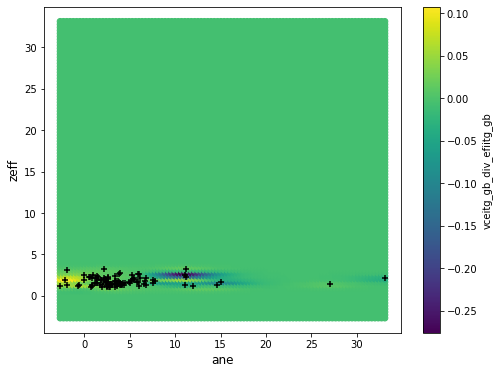

In [13]:
plt.figure(figsize = (8,6))
plt.scatter(test_x[:,0], test_x[:,1], c = output)
plt.colorbar(label =output_dim[0])
plt.scatter(x_train_data[:,:,0].squeeze(), x_train_data[:,:,1].squeeze(),marker='+', color ='black')
plt.xlabel(input_dim[0], fontsize = 12);
plt.ylabel(input_dim[1], fontsize = 12);

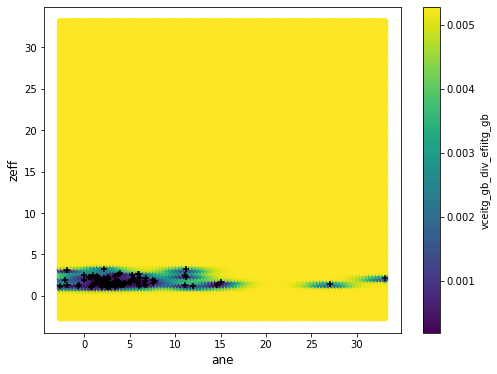

In [14]:
plt.figure(figsize = (8,6))
plt.scatter(test_x[:,0], test_x[:,1], c = out_var)
plt.colorbar(label =output_dim[0])
plt.scatter(x_train_data[:,:,0].squeeze(), x_train_data[:,:,1].squeeze(),marker='+', color ='black')
plt.xlabel(input_dim[0], fontsize = 12);
plt.ylabel(input_dim[1], fontsize = 12);

## 3D Plots

In [15]:
from mpl_toolkits.mplot3d import Axes3D

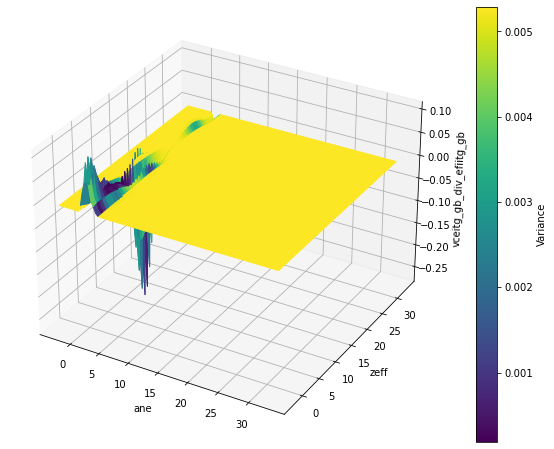

In [16]:
fig = plt.figure(figsize =(12,8))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(x_min0, x_max0 , 100)
y = np.linspace(x_min0, x_max0 , 100)
X, Y = np.meshgrid(x, y)
zs = output
Z = zs.reshape(X.shape)


scamap = plt.cm.ScalarMappable(cmap='viridis')
fcolors = scamap.to_rgba(out_var.reshape(X.shape))

ax.plot_surface(X, Y, Z, facecolors=fcolors, cmap='viridis')
# ax.scatter(x_train_data[:,:,0].squeeze(), x_train_data[:,:,1].squeeze(), y_train_data.squeeze(), marker='+', color ='black')

ax.set_xlabel(input_dim[0])
ax.set_ylabel(input_dim[1])
ax.set_zlabel(output_dim[0])

fig.colorbar(scamap, label = 'Variance')

plt.show()

## Three Input Dimensions One Output Dimension

In [17]:
drop_data = train_data[[f'{input_dim[0]}',f'{input_dim[1]}',f'{input_dim[2]}',f'{output_dim[0]}']].dropna()

In [18]:
print(f"Input dimension to use: {input_dim[0]}, {input_dim[1]} and {input_dim[1]}")
print(f"Input dimension to use: {output_dim[0]}")

Input dimension to use: ane, zeff and zeff
Input dimension to use: vceitg_gb_div_efiitg_gb


In [19]:
x_train_data = drop_data.iloc[:,:3]
y_train_data = drop_data.iloc[:,3:]

assert x_train_data.shape[0] == y_train_data.shape[0]

In [20]:
n = 100
idx = np.random.permutation(n)


In [21]:
x_train_data = torch.tensor(x_train_data.values)[idx]
y_train_data = torch.tensor(y_train_data.values)[idx]

x_train_data = x_train_data.unsqueeze(0)
y_train_data = y_train_data.unsqueeze(0)

x_min0, x_max0 = x_train_data.min(), x_train_data.max()

In [22]:
gp = SingleTaskGP(x_train_data, y_train_data)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll);

In [23]:
# Get into evaluation (predictive posterior) mode
gp.eval()
gp.likelihood.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    t0 = np.linspace(x_min0, x_max0 , 50)
    t1 = np.linspace(x_min0, x_max0 , 50)
    t2 = np.linspace(x_min0, x_max0 , 50)
    
    test_x = torch.tensor(np.array(np.meshgrid(t0, t1, t2)).T.reshape(-1,3), dtype = torch.double)
    print(f'test_shape: {test_x.shape}')
    
    observed_pred = gp.likelihood(gp(test_x))
    
    mean = observed_pred.mean
    variance = observed_pred.variance

test_shape: torch.Size([125000, 3])


In [24]:
output = mean.detach().numpy()
out_var = variance.detach().numpy().squeeze()
output = output.squeeze()

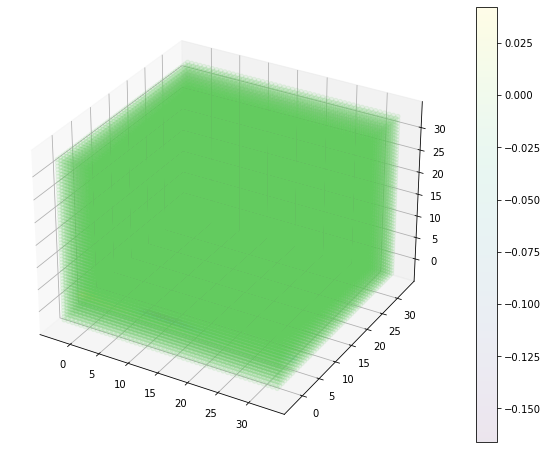

In [25]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')
xs =test_x[:,0]
ys = test_x[:,1]
zs = test_x[:,2]
cs = output
# ax.scatter(xs, ys, zs, c=cs)
p = ax.scatter(xs, ys, zs, c=cs, alpha = 0.1)
fig.colorbar(p)

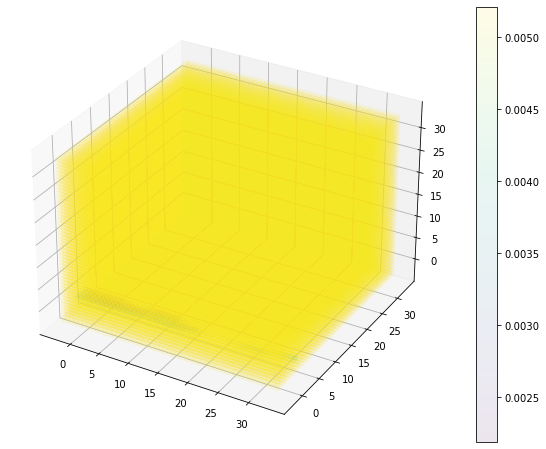

In [26]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')
xs =test_x[:,0]
ys = test_x[:,1]
zs = test_x[:,2]
cs = out_var
p = ax.scatter(xs, ys, zs, c=cs, alpha = 0.1)
fig.colorbar(p)

## Fifteen Input Dimensions - One Output Dimension

In [27]:
keys = [
    "ane",
    "ate",
    "autor",
    "machtor",
    "x",
    "zeff",
    "gammae",
    "q",
    "smag",
    "alpha",
    "ani1",
    "ati0",
    "normni1",
    "ti_te0",
    "lognustar",
]

In [28]:
keys.append(output_dim[0])
print(keys)

['ane', 'ate', 'autor', 'machtor', 'x', 'zeff', 'gammae', 'q', 'smag', 'alpha', 'ani1', 'ati0', 'normni1', 'ti_te0', 'lognustar', 'vceitg_gb_div_efiitg_gb']


In [29]:
drop_data = train_data[keys].dropna()

In [30]:
x_train_data = drop_data.iloc[:,:-1]
y_train_data = drop_data.iloc[:,-1:]

assert x_train_data.shape[0] == y_train_data.shape[0]
assert x_train_data.shape[1] == len(keys)-1

In [31]:
n = 200
idx = np.random.permutation(n)

x_train_data = torch.tensor(x_train_data.values)[idx]
y_train_data = torch.tensor(y_train_data.values)[idx]

x_train_data = x_train_data.unsqueeze(0)
y_train_data = y_train_data.unsqueeze(0)

x_min0, x_max0 = x_train_data.min(), x_train_data.max()

In [32]:
gp = SingleTaskGP(x_train_data, y_train_data)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll);

### Testing

In [41]:
test_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl")
drop_data_test = test_data[keys].dropna()

x_test_data = drop_data_test.iloc[:,:-1]
y_test_data = drop_data_test.iloc[:,-1:]

assert x_test_data.shape[0] == y_test_data.shape[0]
assert x_test_data.shape[1] == len(keys)-1

In [42]:
n = 100
idx = np.random.permutation(n)

x_test_data = torch.tensor(x_test_data.values)[idx]
y_test_data = torch.tensor(y_test_data.values)[idx]

x_test_data = x_test_data.unsqueeze(0)
y_test_data = y_test_data.unsqueeze(0)

x_min0, x_max0 = x_test_data.min(), x_test_data.max()

In [43]:
# Get into evaluation (predictive posterior) mode
gp.eval()
gp.likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    
    observed_pred = gp.likelihood(gp(x_test_data))
    
    mean = observed_pred.mean
    variance = observed_pred.variance

In [44]:
output = mean.detach().numpy()
out_var = variance.detach().numpy().squeeze()
output = output.squeeze()

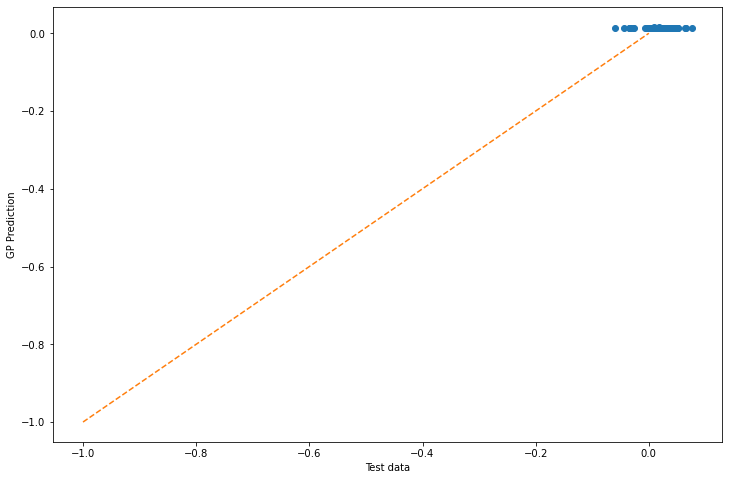

In [45]:
plt.figure(figsize = (12,8))
# plt.scatter(y_test_data.squeeze(), output)
plt.xlabel('Test data')
plt.ylabel('GP Prediction')
plt.errorbar(y_test_data.squeeze(), output,fmt='o', yerr=out_var, ecolor ='black')
plt.plot(np.arange(-1,1),np.arange(-1,1), '--' )


## Leading Fluxes

In [109]:
data = train_data[train_keys + ["efeetg_gb", "efetem_gb", "efiitg_gb"]]
data = data.dropna()

scaler = StandardScaler()
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data), columns = data.columns)

X_train = data[train_keys]
y_train_1 = data["efeetg_gb"]
y_train_2 = data["efetem_gb"]
y_train_3 = data["efiitg_gb"]

n = 1000
idx = np.random.permutation(n)

X_train = torch.tensor(X_train.values)[idx]
y_train_1 = torch.tensor(y_train_1.values)[idx]
y_train_2 = torch.tensor(y_train_3.values)[idx]
y_train_3 = torch.tensor(y_train_3.values)[idx]

X_train = X_train.unsqueeze(0)
y_train_1 = y_train_1.unsqueeze(0).unsqueeze(-1)
y_train_2 = y_train_2.unsqueeze(0).unsqueeze(-1)
y_train_3 = y_train_3.unsqueeze(0).unsqueeze(-1)

In [111]:
gp = SingleTaskGP(X_train, y_train_1)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [113]:
test_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl")

test_data = test_data[train_keys + ["efeetg_gb", "efetem_gb", "efiitg_gb"]]
test_data = test_data.dropna()
test_data = pd.DataFrame(data = scaler.transform(test_data), columns = test_data.columns)


X_test = test_data[train_keys]
y_test_1 = test_data["efeetg_gb"]
y_test_2 = test_data["efetem_gb"]
y_test_3 = test_data["efiitg_gb"]


n = 10_000
idx = np.random.permutation(n)

X_test = torch.tensor(X_test.values)[idx]
y_test_1 = torch.tensor(y_test_1.values)[idx]

X_test = X_test.unsqueeze(0)
y_test_1 = y_test_1.unsqueeze(0)

In [114]:
gp.eval()
gp.likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = gp.likelihood(gp(X_test))
    
    mean = observed_pred.mean
    variance = observed_pred.variance
    
output = mean.detach().numpy()
out_var = variance.detach().numpy().squeeze()
output = output.squeeze()

<ErrorbarContainer object of 3 artists>

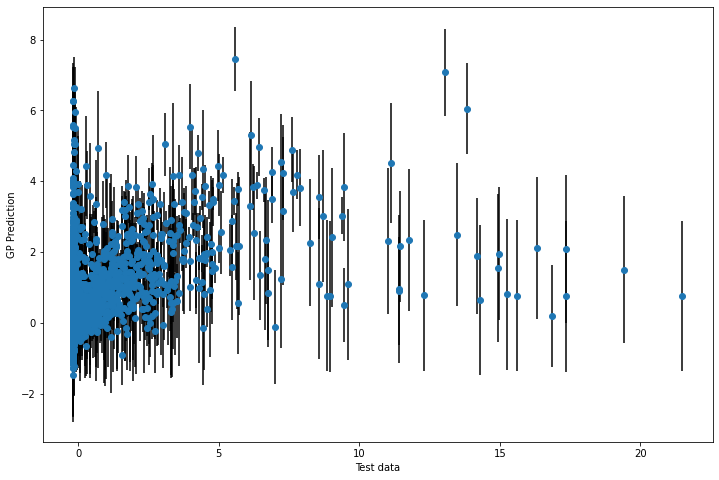

In [117]:
plt.figure(figsize = (12,8))

plt.xlabel('Test data')
plt.ylabel('GP Prediction')
plt.errorbar(y_test_1.squeeze(), output, fmt='o', yerr=out_var, ecolor ='black')